In [1]:
% matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

import sys
sys.path.insert(0, '/home/jr0th/github/segmentation/code/')
import helper.model_builder
import helper.metrics

import skimage.io

import numpy as np

import time

import keras

# build session running on a specific GPU
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "1"
session = tf.Session(config = configuration)

keras.backend.set_session(session)

Using TensorFlow backend.


RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [10]:
img_load_pattern = '/home/jr0th/github/segmentation/data/BBBC022/test/x/all/*.png'

# uncomment the following line to use full images instead of crops
img_load_pattern = '/home/jr0th/github/segmentation/data/BBBC022/test/x_big/*.png'

# use latest checkpoint
weights_path = '/home/jr0th/github/segmentation/checkpoints/DL_on_Hand_boundary_augment/checkpoint_0199.hdf5'

# get images
images = skimage.io.imread_collection(img_load_pattern).concatenate()

# assume that images are all the same shape
n_images = images.shape[0]
dim1 = images.shape[1]
dim2 = images.shape[2]

# build model and load weights
model = helper.model_builder.get_model_1_class(dim1, dim2)

model.load_weights(weights_path)

/home/jr0th/github/segmentation/code/helper/model_builder.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/jr0th/github/segmentation/code/helper/model_builder.py:27: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/jr0th/github/segmentation/code/helper/model_builder.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/jr0th/github/segmentation/code/helper/model_builder.py:33: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/jr0th/github/segmentation/code/helper/mode

# TEST INFERENCE AND POST PROCESSING TIME

Heating up GPU now.
GPU is hot now.
Iteration 1 of 101


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Iteration 2 of 101
Iteration 3 of 101
Iteration 4 of 101
Iteration 5 of 101
Iteration 6 of 101
Iteration 7 of 101
Iteration 8 of 101
Iteration 9 of 101
Iteration 10 of 101
Iteration 11 of 101
Iteration 12 of 101
Iteration 13 of 101
Iteration 14 of 101
Iteration 15 of 101
Iteration 16 of 101
Iteration 17 of 101
Iteration 18 of 101
Iteration 19 of 101
Iteration 20 of 101
Iteration 21 of 101
Iteration 22 of 101
Iteration 23 of 101
Iteration 24 of 101
Iteration 25 of 101
Iteration 26 of 101
Iteration 27 of 101
Iteration 28 of 101
Iteration 29 of 101
Iteration 30 of 101
Iteration 31 of 101
Iteration 32 of 101
Iteration 33 of 101
Iteration 34 of 101
Iteration 35 of 101
Iteration 36 of 101
Iteration 37 of 101
Iteration 38 of 101
Iteration 39 of 101
Iteration 40 of 101
Iteration 41 of 101
Iteration 42 of 101
Iteration 43 of 101
Iteration 44 of 101
Iteration 45 of 101
Iteration 46 of 101
Iteration 47 of 101
Iteration 48 of 101
Iteration 49 of 101
Iteration 50 of 101
Iteration 51 of 101
Iteratio

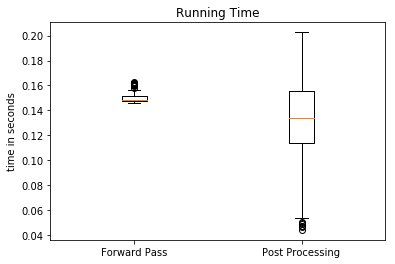

In [13]:
# label = 'PATCH'
# label = 'PATCH_thresh'
label = 'PATCH_remove_small'
# label = 'PATCH_thresh_remove_small'

# label = 'FULL'
# label = 'FULL_thresh'
#label = 'FULL_remove_small'
# label = 'FULL_thresh_remove_small'

N = 101

time_inf = np.zeros(N)
time_pp = np.zeros(N)

batch_size = 10

print('Heating up GPU now.')

# heat up GPU
for i in range(10):
    model.predict(np.zeros((batch_size, dim1, dim2, 1)), batch_size=batch_size)

print('GPU is hot now.')

for i in range(N):
    
    print('Iteration', i+1, 'of', N)
    
    # get random image
    img = images[np.random.randint(0, n_images)]

    # preprocessing
    img_rescaled = np.reshape(img / 255, (-1, dim1, dim2, 1))

    # inference
    start_inf = time.time()
    outline_pred = model.predict(img_rescaled)
    end_inf = time.time()

    time_inf[i] = end_inf - start_inf

    # postprocessing
    outline_pred = outline_pred.squeeze()
    start_pp = time.time()
    contour = helper.metrics.probmap_to_contour(outline_pred)
    segmentation = helper.metrics.contour_to_label(contour, img_rescaled)
    end_pp = time.time()

    time_pp[i] = end_pp - start_pp
    
    # visualize
    visualize = False
    if(visualize):
        plt.imshow(img)
        plt.colorbar()
        plt.title('Image')
        plt.show()

        plt.imshow(outline_pred)
        plt.colorbar()
        plt.title('Outline Probability Map')
        plt.show()

        plt.imshow(contour)
        plt.colorbar()
        plt.title('Thresholded Contours')
        plt.show()

        plt.imshow(segmentation)
        plt.colorbar()
        plt.title('Predicted Segmentation')
        plt.show()

time_inf = time_inf[1:]
time_pp = time_pp[1:]

plt.boxplot([time_inf, time_pp], labels=['Forward Pass', 'Post Processing'])
plt.title('Running Time')
plt.ylabel('time in seconds')
plt.savefig('inf_pp_time_' + label + '.eps', format='eps')

np.save('inf_pp_time_' + label + '.npy',[time_inf, time_pp])

print('Mean time for inference: ', np.mean(time_inf))
print('Mean time for post processing: ', np.mean(time_pp))

print('SD for inference: ', np.std(time_inf))
print('SD for post processing: ', np.std(time_pp))

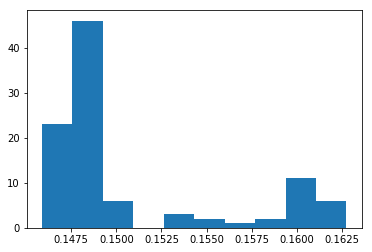

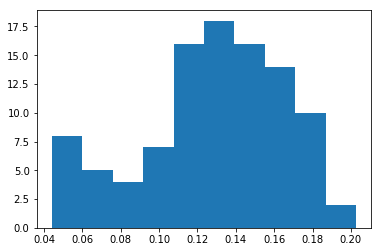

In [14]:
plt.hist(time_inf)
plt.show()

plt.hist(time_pp)
plt.show()


# TEST DEPENDENCY ON BATCH SIZE

In [26]:
max_n_images = 13
batch_size = 10

N = 100 + 1 # first run is thrown away

runtimes_per_image = np.zeros((N, max_n_images))

# print('Heating up GPU now.')

# # heat up GPU
# for i in range(10):
#     model.predict(np.zeros((batch_size, dim1, dim2, 1)), batch_size=batch_size)

# print('GPU is hot now.')

# loop over iterations
for i in range(N):
    
    # loop over number of images
    for n_images in range(1, max_n_images + 1):

        # prepare data
        data = np.zeros((n_images, dim1, dim2, 1))
        for j in range(n_images):
            # get random image
            data[j,:,:,0] = images[np.random.randint(low = 0, high = len(images))]

        # preprocessing
        data = data / 255

        # inference
        time_inf = 0
        start_inf = time.time()
        outline_pred = model.predict(data, batch_size=batch_size)
        end_inf = time.time()

        time_inf = end_inf - start_inf

        # visualize
        visualize = False
        if(visualize):
            plt.imshow(outline_pred[0].squeeze())
            plt.show()

        runtimes_per_image[i,n_images-1] = time_inf / n_images
        print('Time for inference per image:', np.round(runtimes_per_image[i, n_images-1], decimals=4), 'with', n_images, 'samples')

Time for inference per image: 0.1669 with 1 samples
Time for inference per image: 0.1508 with 2 samples
Time for inference per image: 0.1481 with 3 samples
Time for inference per image: 0.1506 with 4 samples
Time for inference per image: 0.1501 with 5 samples
Time for inference per image: 0.151 with 6 samples
Time for inference per image: 0.1501 with 7 samples
Time for inference per image: 0.1527 with 8 samples
Time for inference per image: 0.1507 with 9 samples
Time for inference per image: 0.1525 with 10 samples
Time for inference per image: 0.1528 with 11 samples
Time for inference per image: 0.1512 with 12 samples
Time for inference per image: 0.1517 with 13 samples
Time for inference per image: 0.1546 with 1 samples
Time for inference per image: 0.1487 with 2 samples
Time for inference per image: 0.1499 with 3 samples
Time for inference per image: 0.1506 with 4 samples
Time for inference per image: 0.1509 with 5 samples
Time for inference per image: 0.152 with 6 samples
Time for i

Time for inference per image: 0.1596 with 3 samples
Time for inference per image: 0.1609 with 4 samples
Time for inference per image: 0.1603 with 5 samples
Time for inference per image: 0.1603 with 6 samples
Time for inference per image: 0.1611 with 7 samples
Time for inference per image: 0.1629 with 8 samples
Time for inference per image: 0.1614 with 9 samples
Time for inference per image: 0.1622 with 10 samples
Time for inference per image: 0.1621 with 11 samples
Time for inference per image: 0.1624 with 12 samples
Time for inference per image: 0.1617 with 13 samples
Time for inference per image: 0.1662 with 1 samples
Time for inference per image: 0.1596 with 2 samples
Time for inference per image: 0.1594 with 3 samples
Time for inference per image: 0.1607 with 4 samples
Time for inference per image: 0.1605 with 5 samples
Time for inference per image: 0.1621 with 6 samples
Time for inference per image: 0.1611 with 7 samples
Time for inference per image: 0.1634 with 8 samples
Time for

Time for inference per image: 0.1607 with 4 samples
Time for inference per image: 0.1602 with 5 samples
Time for inference per image: 0.1601 with 6 samples
Time for inference per image: 0.1609 with 7 samples
Time for inference per image: 0.163 with 8 samples
Time for inference per image: 0.1618 with 9 samples
Time for inference per image: 0.1624 with 10 samples
Time for inference per image: 0.1629 with 11 samples
Time for inference per image: 0.1626 with 12 samples
Time for inference per image: 0.1614 with 13 samples
Time for inference per image: 0.1656 with 1 samples
Time for inference per image: 0.1598 with 2 samples
Time for inference per image: 0.1599 with 3 samples
Time for inference per image: 0.1618 with 4 samples
Time for inference per image: 0.1596 with 5 samples
Time for inference per image: 0.1612 with 6 samples
Time for inference per image: 0.1613 with 7 samples
Time for inference per image: 0.1638 with 8 samples
Time for inference per image: 0.1612 with 9 samples
Time for 

Time for inference per image: 0.1606 with 5 samples
Time for inference per image: 0.1605 with 6 samples
Time for inference per image: 0.1604 with 7 samples
Time for inference per image: 0.1632 with 8 samples
Time for inference per image: 0.1608 with 9 samples
Time for inference per image: 0.1621 with 10 samples
Time for inference per image: 0.1632 with 11 samples
Time for inference per image: 0.1625 with 12 samples
Time for inference per image: 0.1615 with 13 samples
Time for inference per image: 0.1657 with 1 samples
Time for inference per image: 0.1597 with 2 samples
Time for inference per image: 0.1602 with 3 samples
Time for inference per image: 0.1603 with 4 samples
Time for inference per image: 0.1604 with 5 samples
Time for inference per image: 0.1608 with 6 samples
Time for inference per image: 0.1609 with 7 samples
Time for inference per image: 0.1633 with 8 samples
Time for inference per image: 0.1611 with 9 samples
Time for inference per image: 0.162 with 10 samples
Time for

Time for inference per image: 0.1614 with 6 samples
Time for inference per image: 0.1611 with 7 samples
Time for inference per image: 0.1636 with 8 samples
Time for inference per image: 0.1614 with 9 samples
Time for inference per image: 0.1626 with 10 samples
Time for inference per image: 0.1623 with 11 samples
Time for inference per image: 0.1618 with 12 samples
Time for inference per image: 0.1617 with 13 samples
Time for inference per image: 0.1652 with 1 samples
Time for inference per image: 0.1599 with 2 samples
Time for inference per image: 0.1601 with 3 samples
Time for inference per image: 0.1618 with 4 samples
Time for inference per image: 0.1605 with 5 samples
Time for inference per image: 0.1604 with 6 samples
Time for inference per image: 0.1606 with 7 samples
Time for inference per image: 0.1635 with 8 samples
Time for inference per image: 0.1611 with 9 samples
Time for inference per image: 0.1615 with 10 samples
Time for inference per image: 0.162 with 11 samples
Time fo

Time for inference per image: 0.1631 with 8 samples
Time for inference per image: 0.1617 with 9 samples
Time for inference per image: 0.1619 with 10 samples
Time for inference per image: 0.1612 with 11 samples
Time for inference per image: 0.1623 with 12 samples
Time for inference per image: 0.1613 with 13 samples
Time for inference per image: 0.165 with 1 samples
Time for inference per image: 0.1598 with 2 samples
Time for inference per image: 0.16 with 3 samples
Time for inference per image: 0.1615 with 4 samples
Time for inference per image: 0.1601 with 5 samples
Time for inference per image: 0.1609 with 6 samples
Time for inference per image: 0.1601 with 7 samples
Time for inference per image: 0.1629 with 8 samples
Time for inference per image: 0.161 with 9 samples
Time for inference per image: 0.1611 with 10 samples
Time for inference per image: 0.162 with 11 samples
Time for inference per image: 0.1619 with 12 samples
Time for inference per image: 0.1612 with 13 samples
Time for 

Time for inference per image: 0.1623 with 10 samples
Time for inference per image: 0.1625 with 11 samples
Time for inference per image: 0.1627 with 12 samples
Time for inference per image: 0.1621 with 13 samples
Time for inference per image: 0.1656 with 1 samples
Time for inference per image: 0.1598 with 2 samples
Time for inference per image: 0.1601 with 3 samples
Time for inference per image: 0.1603 with 4 samples
Time for inference per image: 0.1598 with 5 samples
Time for inference per image: 0.1604 with 6 samples
Time for inference per image: 0.1607 with 7 samples
Time for inference per image: 0.1631 with 8 samples
Time for inference per image: 0.1606 with 9 samples
Time for inference per image: 0.1621 with 10 samples
Time for inference per image: 0.162 with 11 samples
Time for inference per image: 0.1619 with 12 samples
Time for inference per image: 0.1616 with 13 samples
Time for inference per image: 0.1665 with 1 samples
Time for inference per image: 0.1599 with 2 samples
Time 

Time for inference per image: 0.1625 with 12 samples
Time for inference per image: 0.1615 with 13 samples
Time for inference per image: 0.1662 with 1 samples
Time for inference per image: 0.1607 with 2 samples
Time for inference per image: 0.1601 with 3 samples
Time for inference per image: 0.1614 with 4 samples
Time for inference per image: 0.1598 with 5 samples
Time for inference per image: 0.1615 with 6 samples
Time for inference per image: 0.1607 with 7 samples
Time for inference per image: 0.163 with 8 samples
Time for inference per image: 0.1613 with 9 samples
Time for inference per image: 0.1625 with 10 samples
Time for inference per image: 0.1628 with 11 samples
Time for inference per image: 0.1623 with 12 samples
Time for inference per image: 0.1617 with 13 samples
Time for inference per image: 0.1645 with 1 samples
Time for inference per image: 0.1602 with 2 samples
Time for inference per image: 0.16 with 3 samples
Time for inference per image: 0.1604 with 4 samples
Time for 

Time for inference per image: 0.1615 with 13 samples
Time for inference per image: 0.1652 with 1 samples
Time for inference per image: 0.1602 with 2 samples
Time for inference per image: 0.1601 with 3 samples
Time for inference per image: 0.1611 with 4 samples
Time for inference per image: 0.1608 with 5 samples
Time for inference per image: 0.1612 with 6 samples
Time for inference per image: 0.1614 with 7 samples
Time for inference per image: 0.1631 with 8 samples
Time for inference per image: 0.161 with 9 samples
Time for inference per image: 0.1624 with 10 samples
Time for inference per image: 0.1627 with 11 samples
Time for inference per image: 0.1617 with 12 samples
Time for inference per image: 0.1621 with 13 samples
Time for inference per image: 0.1656 with 1 samples
Time for inference per image: 0.1599 with 2 samples
Time for inference per image: 0.1601 with 3 samples
Time for inference per image: 0.1616 with 4 samples
Time for inference per image: 0.16 with 5 samples
Time for i

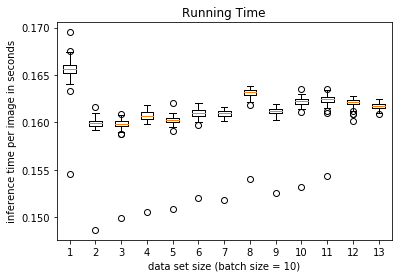

In [39]:
plt.boxplot(runtimes_per_image[1:])
plt.title('Running Time')
plt.ylabel('inference time per image in seconds')
plt.xlabel('data set size (batch size = '+str(batch_size)+')')
plt.savefig('runtime_batch_size.eps', format='eps')
np.save('runtimes_per_image.npy', runtimes_per_image)